<center> <img src = img.png alt="drawing" style="width:400px;">

In [433]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn import preprocessing
# from sklearn.feature_selection import chi2
# from sklearn.feature_selection import f_classif
import category_encoders as ce
import re
import nums_from_string
import geopy.distance

# инструменты для лингвистического анализа:
import string
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import textblob
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer

# инструменты для визуализации:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# параметры отображения содержимого на экране:
from IPython.display import display
from termcolor import colored
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_rows', 200)

# инструменты для построения модели:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

# 0. Исходные данные:

In [434]:
hotels = pd.read_csv('hotels_train.csv')

In [435]:
display(hotels.head())
display(hotels.info())
print(f'\nСтолбцы с явными пропусками данных:\n{hotels.isnull().sum()[hotels.isnull().sum() > 0]}')

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough London W1J 8LT United Kingdom,581,2/19/2016,8.400,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.000,"[' Leisure trip ', ' Couple ', ' Studio Suite ', ' Stayed 2 nights ', ' Submitted from a mobile device ']",531 day,51.508,-0.144
1,130 134 Southampton Row Camden London WC1B 5AF United Kingdom,299,1/12/2017,8.300,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.300,"[' Business trip ', ' Couple ', ' Standard Double Room ', ' Stayed 1 night ']",203 day,51.521,-0.123
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.900,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.500,"[' Leisure trip ', ' Solo traveler ', ' Modern Double Room Echo ', ' Stayed 3 nights ', ' Submitted from a mobile device ']",289 day,48.845,2.326
3,216 Avenue Jean Jaures 19th arr 75019 Paris France,34,9/22/2015,7.500,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotlessly clean excellent location,11,8,10.000,"[' Leisure trip ', ' Solo traveler ', ' Standard Room with 1 Double Bed ', ' Stayed 1 night ']",681 day,48.889,2.395
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.500,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Breakfasts were just extraordinary Room was clean quiet and very spacious,20,10,9.600,"[' Business trip ', ' Couple ', ' Standard Double or Twin Room ', ' Stayed 6 nights ']",516 day,52.386,4.847


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

None


Столбцы с явными пропусками данных:
lat    2448
lng    2448
dtype: int64


#### Первоначальная версия датасета содержит 17 полей со следующей информацией:

hotel_address — адрес отеля;
review_date — дата, когда рецензент разместил соответствующий отзыв;
average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
hotel_name — название отеля;
reviewer_nationality — страна рецензента;
negative_review — отрицательный отзыв, который рецензент дал отелю;
review_total_negative_word_counts — общее количество слов в отрицательном отзыв;
positive_review — положительный отзыв, который рецензент дал отелю;
review_total_positive_word_counts — общее количество слов в положительном отзыве;
reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;
total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;
total_number_of_reviews — общее количество действительных отзывов об отеле;
tags — теги, которые рецензент дал отелю;
days_since_review — количество дней между датой проверки и датой очистки;
additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
lat — географическая широта отеля;
lng — географическая долгота отеля.

### <span style="color:blue">Немного о целевом признаке: ('reviewer_score')</span>
Оценим распределение величины

In [436]:
# проведем тест на нормальность:
alpha = 0.05
_, p = stats.normaltest(hotels['reviewer_score'])

print('Для распределения оценок туристов: p=%.4f' % p)
print('Данные распределены нормально.') if p > alpha/2 else print('Данные не распределены нормально.')

Для распределения оценок туристов: p=0.0000
Данные не распределены нормально.


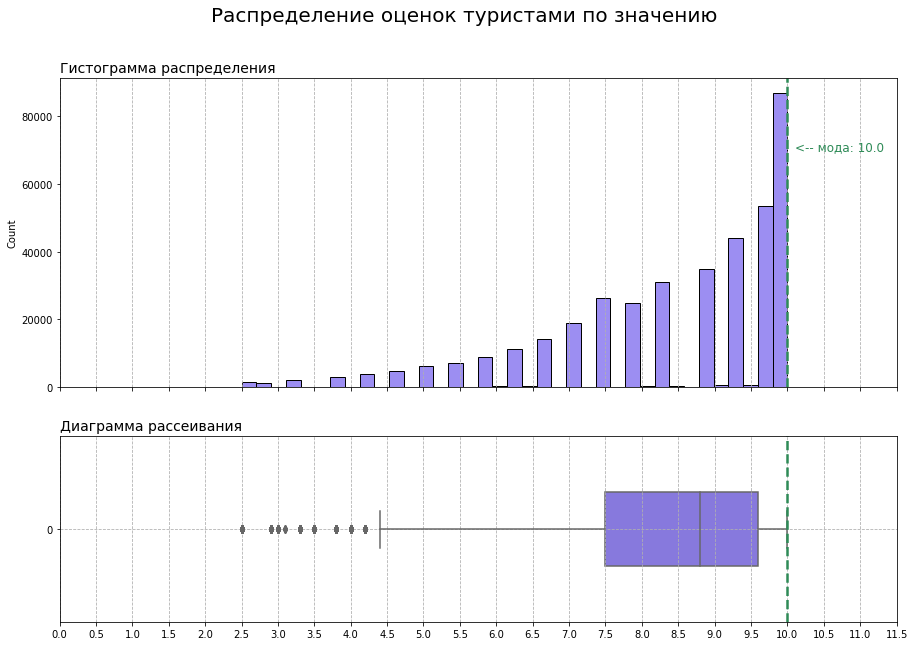

In [437]:
# подготовим данные для диаграмм:
data_score = hotels['reviewer_score']
mode_score = (hotels['reviewer_score'].mode()).max()
colors_score = ['mediumslateblue', 'seagreen']

# формируем размеры диаграмм:
fig1, ax1 = plt.subplots(nrows=2, ncols=1, sharex='col', figsize=(15, 10), gridspec_kw={'height_ratios': [5, 3]})
plt.suptitle('Распределение оценок туристами по значению', size=20)

# строим гистограмму распределения:
ax1[0].set_title('Гистограмма распределения', ha='left', x=.0, fontsize=14)
sns.histplot(ax=ax1[0], data=data_score, bins=len(hotels['reviewer_score'].value_counts()), color=colors_score[0]).xaxis.grid(linestyle='--')

# строим коробчатую диаграмму:
ax1[1].set_title('Диаграмма рассеивания', ha='left', x=.0, fontsize=14)
sns.boxplot(ax=ax1[1], data=data_score, color=colors_score[0], width=0.4, orient='h').grid(linestyle='--')

# для наглядности добавим линию модального значения:
ax1[0].axvline(x=mode_score, color=colors_score[1], ls='--', lw=2.5)
ax1[0].text(10.1, 70000, f'<-- мода: {mode_score}', fontsize = 12, color=colors_score[1])
ax1[1].axvline(x=mode_score, color=colors_score[1], ls='--', lw=2.5)

ax1[1].set_xticks(np.arange(0, 12, 0.5))
ax1[1].set_xlabel('');

##### И тест однозначно показывает, что данные не распределены нормально. А вот на графике - "все не так однозначно". В уровне количества выставленных оценок - шаг от шага наблюдаются "взлеты и падения" показателей. При поступательном движении по шкале оценок - некоторые оценки более популярны, некоторые - почти не заметны, некоторые - отсутствуют вовсе.
##### Но есть что-то нормальное, в это вроде бы ненормальном распределении.
##### Это связано со спецификой расчета и округления средней оценки отзыва на Booking.com на основании оценок по отдельным категориям. Некоторые категории оценки, например 9.8 или 7.2 - не встречаются совсем. Этот средний балл невозможно получить ни при какой комбинации оценок по различным параметрам.

<left> <img src = img_score.png alt="Drawing" width=400, height=400>

In [438]:
# это демонстрирует и таблица уникальных значений:
hotels['reviewer_score'].value_counts()

10.000    86803
9.600     53502
9.200     44053
8.800     34795
8.300     30903
7.500     26164
7.900     24901
7.100     18529
6.700     14117
6.300     11244
5.800      8962
5.400      7082
5.000      6278
4.600      4660
4.200      3827
3.800      3017
3.300      2063
2.500      1632
2.900      1211
9.500       523
9.000       483
8.000       388
8.500       379
7.000       293
6.500       274
6.000       184
5.500       161
4.500        97
4.000        66
3.500        61
9.400        47
8.100        28
3.000        25
6.900        23
5.600        13
4.400         9
3.100         6
Name: reviewer_score, dtype: int64

Рецензент оценивает 6 категорий в 4 степенях. Каждая категория - 10 баллов суммарно, за каждый шаг + 2,5 балла к сумме по категории, а итоговая оценка - среднее арифметическое с округлением до десятых.
Если посмотреть на динамику самых популярных оценок - то это те самые 10, 9.6, 9.2 и так далее. Вполне себе нормальное одностороннее распределение.

А вот откуда взялись остальные оценки, с шагом по 0.5 - не очень понятно. Суммарное их количество - меньше процента от общего числа. Может это, например, результаты тестирования альтернативной системы оценивания, или просто поврежденные данные, или еще что-то.
В любом случае, я считаю, что наша зависимая переменная - это нормально распределенная переменная. И к ней применимы все закономерности данного вида распределений.

Строим диаграмму qq-plot


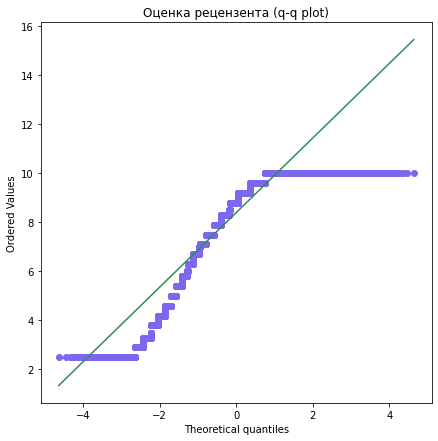

In [439]:
# диаграмма теоретических квартилей:
fig0, ax0 = plt.subplots(figsize=(7, 7))

stats.probplot(hotels['reviewer_score'], plot=ax0)
ax0.set_title('Оценка рецензента (q-q plot)')
ax0.get_lines()[0].set_color('mediumslateblue')
ax0.get_lines()[0].set_markerfacecolor('mediumslateblue')
ax0.get_lines()[1].set_color('seagreen')

plt.show()

##### Вот и я о том же!

# 1. Исследование и проектирование признаков (FEATURE ENGINEERING):

Целью данного раздела будем считать максимальную адаптацию информации под нужды модели машинного обучения. Ситуация осложняется тем, что я не очень понимаю какой тип данных может оптимизировать алгоритм в "случайном лесу" (построение прогноза методом RandomForestRegression). Но на этом этапе пусть моим девизом станет - "минимум слов - максимум цифр".

Для каждого признака я буду придерживаться следующего алгоритма:
* исследование данных;
* гипотеза о влиянии на целевую переменную ->
    - либо решение об удалении признака
    - либо выбор метода преобразования
    - либо решение о формировании новых признаков на базе текущего
* оцифровка и преобразование (если нужно) - кодирование / нормализация / стандартизация;

## 1.1 ГРУППА ПРИЗНАКОВ ХАРКТЕРИЗУЮЩИХ ОТЕЛЬ
***Название и Адрес отеля ('hotel_address', 'hotel_name')***
***Координаты отеля - Географическая широта и долгота отеля ('lat', 'lng')***
***Средний балл отеля за последний год ('average_score')***
***Общее количество отзывов об отеле ('total_number_of_reviews')***
***Общее количество оценок без отзывов ('additional_number_of_scoring')***

### <span style="color:blue">НАЗВАНИЕ ОТЕЛЯ ('hotel_name')</span>

Название отеля можно использовать для обучения модели, только если его кодировать. Код названия сам по себе вряд ли может что-то сообщить. Отелей больше тысячи и числовой код скорее запутает модель из-за своей размерности, не несущей никакой смысловой нагрузки.

Попробуем сообщить модели хоть какую-то осмысленную информацию. Название - это уникальная характеристика отеля. Отели можно отсортировать, например, по популярности (кол-во отзывов) или по рейтингу (средний бал). Но тогда получится, что наш признак будет дублировать по смыслу или столбец с количеством отзывов, или столбец со средней оценкой.

Я склоняюсь скорее к идеи удаления этого столбца, но позже, на этапе анализа всех признаком и их влияния на целевую переменную.

А пока закодируем название, используя обе эти характеристики. Пусть у нас будут только лучшие по отзывам и достаточно популярные отели.

In [440]:
# исследуем данные о названии и адресе отеля на наличие пропуском и дубликатов:
pivot_n = hotels[['hotel_address', 'hotel_name']].groupby(by='hotel_name').nunique()
name_rep = pivot_n[pivot_n['hotel_address'] != 1].index.to_list()
addresses_rep = hotels[hotels['hotel_name'].isin(name_rep)][['hotel_name', 'hotel_address']].value_counts()

print(colored('Дублирование Названия отеля:', 'green'))
display(addresses_rep)

# чтобы различать эти отели при анализе - добавим в название город отеля:
hotels['hotel_name'] = hotels.apply(
    lambda row: (row['hotel_name'] + ' ' + row['hotel_address'].split()[-2])
    if (row['hotel_name'] in name_rep)
    else row['hotel_name'], axis=1)

print(colored('\nПроверим полученные изменения:', 'green'))
display(hotels[hotels['hotel_name'].str.contains(name_rep[0])]['hotel_name'].value_counts())

# выделим топ лучших по рейтингу и имеющих порог в 100 отзывов:
hotels_names = hotels.groupby('hotel_name')['average_score'].agg(['mean', 'count'])
hotels_top = hotels_names[(hotels_names['mean'] >= 9.0) & (hotels_names['count'] >= 100)]

print(colored('\nЛучшие по отзывам отели, имеющие минимум 100 отзывов:', 'green'))
display(hotels_top)

hotels['hotel_cat'] = hotels['hotel_name'].apply(lambda n: n if n in hotels_top.index else 'other')

# применим порядковое кодирование:
ord_encoder = ce.OrdinalEncoder()
hotels['hotel_cat'] = hotels['hotel_cat'].astype('category')
hotels_bin = ord_encoder.fit_transform(hotels['hotel_cat'])
hotels = pd.concat([hotels, hotels_bin], axis=1)


# удалим исходный столбец
col = hotels.columns.tolist()
col[18] = 'hotel_code'

hotels.set_axis(col, axis=1, inplace=True)
hotels.drop('hotel_cat', axis=1);

Дублирование Названия отеля:


hotel_name    hotel_address                                             
Hotel Regina  Bergara 2 4 Eixample 08002 Barcelona Spain                    440
              Rooseveltplatz 15 09 Alsergrund 1090 Vienna Austria           222
              Via Cesare Correnti 13 Milan City Center 20123 Milan Italy     47
dtype: int64


Проверим полученные изменения:


Hotel Regina Barcelona    440
Hotel Regina Vienna       222
Hotel Regina Milan         47
Name: hotel_name, dtype: int64


Лучшие по отзывам отели, имеющие минимум 100 отзывов:


,mean,count
hotel_name,,
Acad mie H tel Saint Germain,9.000,192
Alma Barcelona GL,9.200,136
Amba Hotel Charing Cross,9.300,581
Ambassade Hotel,9.300,437
Andaz Amsterdam Prinsengracht A Hyatt Hotel,9.300,157
Andaz London Liverpool Street,9.000,383
Aparthotel Arai 4 Superior,9.300,160
Apex City Of London Hotel,9.000,789
Apex London Wall Hotel,9.100,325


### <span style="color:blue">АДРЕС ОТЕЛЯ ('hotel_address')</span>

Из адреса можно извлечь гораздо больше полезной информации, чем из названия. Страна, город и индекс как характеристика района могут стать дополнительными признаками!

Идентифицировать район города можно по индексу в строке адреса отеля. Район города способен сильно повлиять на впечатление туриста об отеле. Среди прочих параметров многие туристы, оставляющие отзыв на Booking.com часто оценивают месторасположение отеля.

In [441]:
addresses = pd.Series(hotels['hotel_address'].unique())

print(colored('\nРассмотрим внимательно структуру строк с данными адреса:', 'green'))
display(addresses)

# для вычленения гео-параметров можно было бы воспользоваться locationtagger, но он работает довольно медленно и с ошибками
# поскольку у нас не большое количество уникальных стран и городов в данных - воспользуемся простой обработкой текста:
countries = addresses.apply(lambda x: x.split()[-1])
countries = countries.apply(lambda x: 'United Kingdom' if x == 'Kingdom' else x)

cities = addresses.apply(lambda x: x.split()[-2])
cities = cities.apply(lambda x: 'London' if x == 'United' else x)

addresses = pd.DataFrame({'address': addresses, 'country': countries, 'city': cities})

print(colored('\nВ каждой стране отели представлены только из одного города:', 'green'))
display(addresses.groupby(['country', 'city']).count())

# можно добавить в данные что-то одно - я выберу страну (так потом будет удобнее сопоставлять с национальностью рецензента)
hotels['hotel_country'] = hotels['hotel_address'].apply(
    lambda x: 'United Kingdom' if x.split()[-1] == 'Kingdom' else x.split()[-1])

# кодируем информацию о стране:
hotels['hotel_country'] = hotels['hotel_country'].astype('category')
hotels['hotel_country_code'] = hotels['hotel_country'].cat.codes


Рассмотрим внимательно структуру строк с данными адреса:


0       Stratton Street Mayfair Westminster Borough London W1J 8LT United Kingdom
1                   130 134 Southampton Row Camden London WC1B 5AF United Kingdom
2                                151 bis Rue de Rennes 6th arr 75006 Paris France
3                              216 Avenue Jean Jaures 19th arr 75019 Paris France
4                                       Molenwerf 1 1014 AG Amsterdam Netherlands
                                          ...                                    
1488                              Viriotgasse 5 09 Alsergrund 1090 Vienna Austria
1489                                     8 rue d Anjou 8th arr 75008 Paris France
1490        Prinsengracht 717 Amsterdam City Center 1017 JW Amsterdam Netherlands
1491                          43 Rue De l Abb Gr goire 6th arr 75006 Paris France
1492                      Johann Staud Stra e 32 16 Ottakring 1160 Vienna Austria
Length: 1493, dtype: object


В каждой стране отели представлены только из одного города:


,,address
country,city,
Austria,Vienna,158
France,Paris,458
Italy,Milan,162
Netherlands,Amsterdam,105
Spain,Barcelona,211
United Kingdom,London,399


In [442]:
# добавим почтовый индекс отеля как идентификатор района:
def get_postcode(address):
    address_list = address.split()
    postcode_place = {'Kingdom': -4, 'Spain': -3, 'France': -3, 'Austria': -3, 'Netherlands': -4, 'Italy': -3}
    postcode = str(address_list[postcode_place[address_list[-1]]])
    return postcode[:-1] if (address_list[-1] == 'Kingdom' and postcode[-1].isalpha()) else postcode

hotels['hotel_postcode'] = hotels['hotel_address'].apply(get_postcode)

# из файла с данными об расположении центральных районов данных городов - определим категорию района:
districts = pd.read_excel('regions.xlsx', sheet_name='postcodes')
districts['PostCode'] = districts['PostCode'].apply(lambda x: str(x))
districts = districts.set_index('PostCode')
districts = districts.to_dict()
districts = districts['Type of District']

hotels['district_type'] = hotels['hotel_postcode'].apply(lambda x: districts[x])

# кодируем информацию о типе района:
def get_district_code(district_type, country_code):
    country_code += 1
    if district_type == 'History Center':
        return country_code * 3
    elif district_type == 'Center':
        return country_code * 2
    elif district_type == 'Other':
        return country_code
    else:
        return 0

hotels['district_code'] = hotels.apply(lambda row: get_district_code(row['district_type'], row['hotel_country_code']), axis=1)

# присвоим каждому району категорию в зависимости от популярности отелей в данной местности у туристов
# для этого нормализуем информацию о среднем рейтинге отеля в зависимости от индекса
pivot_adr = pd.pivot_table(hotels, index='hotel_postcode', values='average_score', aggfunc='mean')
pivot_adr = pivot_adr.reindex(pivot_adr['average_score'].sort_values(ascending=False).index)

mm_scaler = preprocessing.MinMaxScaler()
x_data = pivot_adr.values
x_scaled = mm_scaler.fit_transform(x_data)
pivot_adr['district_rating'] = x_scaled

hotels['district_rating'] = hotels['hotel_postcode'].apply(lambda x: pivot_adr['district_rating'][x])

hotels[['hotel_address', 'hotel_postcode', 'district_rating']][:10]

,hotel_address,hotel_postcode,district_rating
0,Stratton Street Mayfair Westminster Borough London W1J 8LT United Kingdom,W1,0.546
1,130 134 Southampton Row Camden London WC1B 5AF United Kingdom,WC1,0.494
2,151 bis Rue de Rennes 6th arr 75006 Paris France,75006,0.748
3,216 Avenue Jean Jaures 19th arr 75019 Paris France,75019,0.255
4,Molenwerf 1 1014 AG Amsterdam Netherlands,1014,0.647
5,Via Mecenate 121 20138 Milan Italy,20138,0.434
6,97 Cromwell Road Kensington and Chelsea London SW7 4DN United Kingdom,SW7,0.495
7,Josefsgasse 4 6 08 Josefstadt 1080 Vienna Austria,1080,0.643
8,190 Queen s Gate Kensington and Chelsea London SW7 5EX United Kingdom,SW7,0.495
9,Holland Park Avenue Kensington and Chelsea London W11 4UL United Kingdom,W11,0.374


#### <span style="color:green">Визуализируем соотношение средних значений целевой переменной в зависимости от района расположения отеля:</span>

In [443]:
# посмотрим, отличаются ли средние оценки отелей, в зависимости от района расположения:
pivot_adr = pd.pivot_table(hotels,
                           index=['hotel_country', 'district_type', 'hotel_postcode'],
                           values='reviewer_score',
                           aggfunc='mean')

pivot_adr = pivot_adr.reindex(pivot_adr['reviewer_score'].sort_values(ascending=False).index)

pivot_adr[:10]

reviewer_score
hotel_country  district_type  hotel_postcode                
Netherlands    Center         1015                     9.444
United Kingdom Center         SE11                     9.369
Netherlands    Other          1097                     9.332
               Center         1016                     9.329
               Other          1067                     9.220
Austria        Center         1015                     9.217
United Kingdom History Center EC2                      9.106
               Other          E15                      8.986
Spain          Center         08010                    8.959
                              08037                    8.949

### <span style="color:blue">ГЕОГРАФИЧЕСКИЕ КООРДИНАТЫ ОТЕЛЯ ('lat', 'lng')</span>

Вообще координаты сами по себе мало что могут сообщить модели, но можно попробовать извлечь из них какую-то полезную информацию. Например расстояние до центра города. Из информации о датасете мы помним, что именно в этих столбцах есть пропуски. Сначала удалим пропуски, затем добавим новый признак.

In [444]:
count_hotels_without_coor = len(hotels[hotels.isnull().any(1)]['hotel_name'].value_counts())
print(f'Количество отелей с отсутствующими координатами: {count_hotels_without_coor}')

# вычисляем средние значения координат для каждого района:
pivot_coor = pd.pivot_table(hotels, index='hotel_postcode', values=['lat', 'lng'], dropna=True, aggfunc='mean')

# заполняем отсутствующие координаты:
hotels['lat'] = hotels.apply(
    lambda row: pivot_coor['lat'][row['hotel_postcode']] if np.isnan(row['lat']) else row['lat'], axis=1)
hotels['lng'] = hotels.apply(
    lambda row: pivot_coor['lng'][row['hotel_postcode']] if np.isnan(row['lng']) else row['lng'], axis=1)

# для формирования нового признака нужны координаты центра каждого города (с сайта: https://dateandtime.info/):
centers = pd.DataFrame(
    data = [
        ['United Kingdom', 'London', 51.5085300, -0.1257400],
        ['France', 'Paris', 48.8534100, 2.3488000],
        ['Spain', 'Barcelona', 41.3887900, 2.1589900],
        ['Italy', 'Milan', 45.4642700, 9.1895100],
        ['Austria', 'Vienna', 48.2084900, 16.3720800],
        ['Netherlands', 'Amsterdam', 52.3740300, 4.8896900],
    ],
    columns= ['country', 'city', 'center_lat', 'center_lng']
).set_index('country')


def get_to_center_distance(country, lng, lat):
    center_lat = centers['center_lat'][country]
    center_lng = centers['center_lng'][country]

    return geopy.distance.geodesic([center_lng, center_lat], [lng, lat]).km

# можно одной строкой кода вычислять координаты для каждой строки DataFrame, но geopy.distance.geodesic функция довольно медленная
# hotels['hotel_distance_to_center'] = hotels.apply(lambda row: get_to_center_distance(row['hotel_country'], row['lng'], row['lat']), axis=1)

# чтобы не обрабатывать 500 тыс. строк посчитаем эту характеристику для каждого отеля и потом сопоставить полученные результаты:
hotels_unique = hotels[['hotel_name', 'hotel_country', 'lng', 'lat']].drop_duplicates()
hotels_unique['hotel_distance_to_center'] = hotels_unique.apply(
    lambda row: get_to_center_distance(row['hotel_country'], row['lng'], row['lat']), axis=1)
hotels_unique.drop(['hotel_country', 'lng', 'lat'], axis=1, inplace=True)
hotels = hotels.merge(hotels_unique, how='left', on='hotel_name', sort=False)

# думаю, теперь столбцы с координатами можно удалить:
hotels.drop(['lng', 'lat'], axis=1, inplace=True)

print(colored('\nПроверим новый признак:', 'green'))
hotels[['hotel_name', 'hotel_distance_to_center']]

Количество отелей с отсутствующими координатами: 17

Проверим новый признак:


,hotel_name,hotel_distance_to_center
0,The May Fair Hotel,1.984
1,Mercure London Bloomsbury Hotel,1.420
2,Legend Saint Germain by Elegancia,2.712
3,Mercure Paris 19 Philharmonie La Villette,6.402
4,Golden Tulip Amsterdam West,4.886
...,...,...
386798,Hotel Moonlight,7.400
386799,BEST WESTERN PLUS Amedia Wien,3.484
386800,Bloomsbury Palace Hotel,1.488
386801,The Marble Arch London,3.866


### <span style="color:blue">СРЕДНИЙ БАЛЛ ОТЕЛЯ ('average_score')</span>

Кажется, что это один из самых самодостаточных признаков. Это количественный параметр отеля, в той же размерности и формате, что и целевая переменная. Никаких преобразований с ним выполнять не нужно, а его влияние на показатели целевой переменной оценим в следующем блоке - анализе признаков.

### <span style="color:blue">ОБЩЕЕ КОЛИЧЕСТВО ОТЗЫВОВ ОБ ОТЕЛЕ ('total_number_of_reviews')</span>

Этот показатель говорит о популярности и/или размере отеля. Но, по моему субъективному ощущению, этот фактор не сильно влияет на оценку туриста.

In [445]:
# удалим этот признак и непонятный параметр с количеством действительных оценок:
hotels.drop(['total_number_of_reviews', 'additional_number_of_scoring'], axis=1, inplace=True)

## 1.2 ГРУППА ПРИЗНАКОВ ХАРКТЕРИЗУЮЩИХ РЕЦЕНЗЕНТА И ОПЫТ ПРЕБЫВАНИЯ В ОТЕЛЕ

***Страна рецензента ('reviewer_nationality')***
***Теги, которые рецензент дал отелю ('tags')***
***Количество отзывов, которые рецензенты дали в прошлом ('total_number_of_reviews_reviewer_has_given')***

### <span style="color:blue">СТРАНА РЕЦЕНЗЕНТА ('reviewer_nationality')</span>

На самом деле, я думаю, что не столько страна, сколько социокультурные особенности представителей определенных регионов, действительно могут сказываться на оценках отелей.

Например, туристы из англо-говорящих стран, почти никогда не сталкиваются с языковым барьером в Европейских отелях. А это немаловажный фактор при заселении, выяснении дополнительной информации и решении возникающих проблем. Отсюда следует, что скорее всего такие туристы будут более довольны пребыванием в отеле.

А вот туристы из ближневосточных стран - могут быть более недовольными европейскими отелями, чем остальные, так как их образ жизни сильнее остальных отличается от европейского.

Добавим дополнительные признаки:

In [446]:
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].apply(lambda x: x.strip())
print(f'Представители {len(hotels["reviewer_nationality"].value_counts())} стран являются рецензентами.')

# проанализируем например 40 самых распространенных стран, из которых приезжают туристы и выделим общие группы:
print(colored('\nСамые популярные страны:', 'green'))
print(list(hotels['reviewer_nationality'].value_counts(ascending=False)[:40].index))

# выделим основные англоязычные страны:
english_list = ['United Kingdom', 'United States of America', 'Australia', 'Canada', 'New Zealand']
hotels['reviewer_en'] = hotels['reviewer_nationality'].apply(lambda x: 1 if x in english_list else 0)

# выделим мусульманские страны ближневосточного региона:
muslim_list = ['United Arab Emirates', 'Saudi Arabia', 'Turkey', 'Kuwait', 'Qatar', 'Oman']
hotels['reviewer_n_est'] = hotels['reviewer_nationality'].apply(lambda x: 1 if x in muslim_list else 0)

# добавим признак резидентства туриста по отношению к стране, в которой находится отель:
hotels['reviewer_resident'] = hotels.apply(lambda row: 1 if row['reviewer_nationality'] == row['hotel_country'] else 0, axis=1)

# кодируем информацию о стране рецензента:
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].astype('category')
hotels['reviewer_nationality_cat'] = hotels['reviewer_nationality'].cat.codes

Представители 225 стран являются рецензентами.

Самые популярные страны:
['United Kingdom', 'United States of America', 'Australia', 'Ireland', 'United Arab Emirates', 'Saudi Arabia', 'Netherlands', 'Switzerland', 'Canada', 'Germany', 'France', 'Israel', 'Italy', 'Belgium', 'Turkey', 'Kuwait', 'Spain', 'Romania', 'Russia', 'South Africa', 'China', 'Sweden', 'India', 'Greece', 'New Zealand', 'Singapore', 'Hong Kong', 'Poland', 'Qatar', 'Austria', 'Egypt', 'Norway', 'Czech Republic', 'Lebanon', 'Hungary', 'Malaysia', 'Thailand', 'Brazil', 'Portugal', 'Finland']


#### <span style="color:green">Визуализируем соотношение средних значений целевой переменной в разрезе полученных признаков:</span>

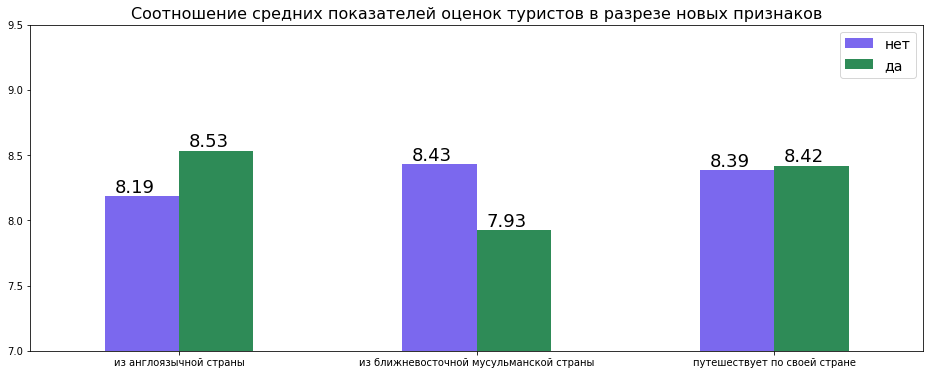

In [447]:
# подготовим данные для диаграммы:
pivot = pd.DataFrame({'из англоязычной страны': hotels.groupby('reviewer_en')['reviewer_score'].mean(),
                      'из ближневосточной мусульманской страны': hotels.groupby('reviewer_n_est')['reviewer_score'].mean(),
                      'путешествует по своей стране': hotels.groupby('reviewer_resident')['reviewer_score'].mean()}).T

# строим диаграмму:
fig2, ax2 = plt.subplots(figsize=(16, 6))
pivot_barplot = pivot.plot(ax=ax2, kind='bar', color=['mediumslateblue', 'seagreen'], rot=0)
ax2.set_title('Соотношение средних показателей оценок туристов в разрезе новых признаков', size=16)
ax2.legend(['нет', 'да'], loc='upper right', fontsize=14)

# для наглядности добавим на диаграмму подписи данных:
for p in pivot_barplot.patches:
    pivot_barplot.annotate('{:.2f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()),
    ha='center', va='bottom', fontsize=18)

plt.ylim(7, 9.5);

### <span style="color:blue">ТЭГИ('tags')</span>

В строке с тэгами содержится много важной и интересной информации.

Можно выделить 6 типов тегов:
- путешествие с домашними животными
- путешествие по работе / отдых
- путешествие в каком составе (один, пара, компания друзей, семья с маленькими / взрослыми детьми, группа)
- категория номера
- длительность поездки
- доступ осуществляется с мобильного устройства

Рассмотрим внимательно категории номеров. Возможно получится выделить их в группы. Кажется, что отзывы о пребывании туристов, которые останавливаются в большом клубном номере с видом и маленьком экономе могут сильно отличаться.

Из типа номера дополнительно выделим признак - номер с видом (думаю, что средний балл отзывов гостей таких номеров должен быть выше обычных).


Визуализируем самые популярные теги набора данных:


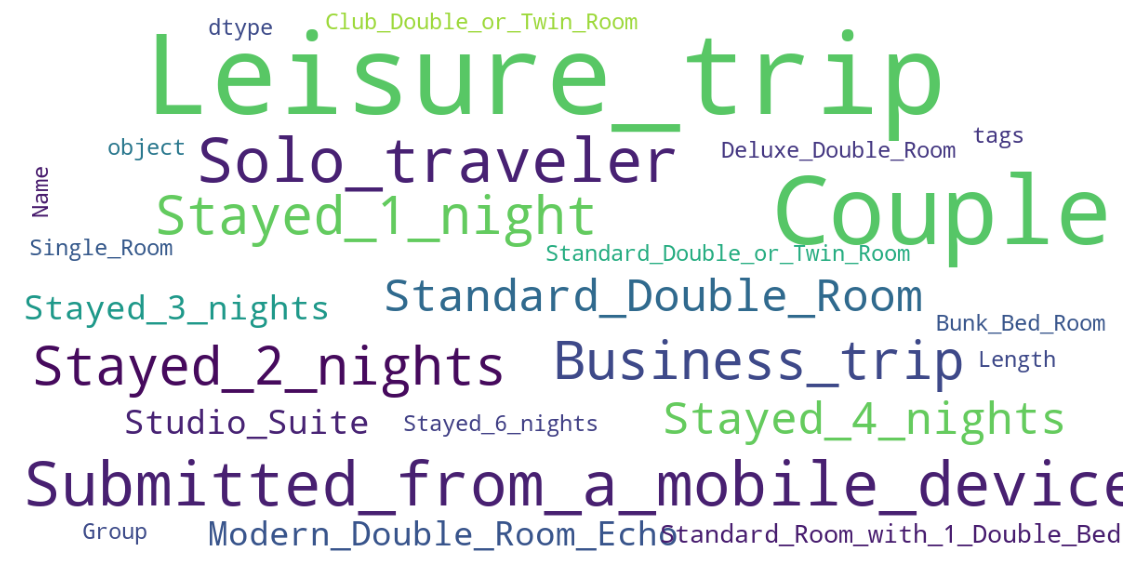

In [448]:
def get_tags_string(tags_data):
    tags_data = tags_data.replace('[', '').replace(']', '').replace("'", '')
    tags_list = tags_data.split(',')

    tags_string = ''
    for teg in tags_list:
        teg = teg.strip().replace(' ', '_')
        tags_string = tags_string + teg + ' '

    return tags_string

def show_wordcloud(data, background_color, colormap):
    wordcloud = WordCloud(
        background_color = background_color,
        colormap = colormap,
        max_font_size = 40,
        max_words=100,
        scale = 3,
        random_state = 42
    ).generate(str(data))

    plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.show()

print('Визуализируем самые популярные теги набора данных:')
cloud = hotels['tags'].apply(get_tags_string)
show_wordcloud(cloud, 'white', 'viridis')

In [449]:
hotels['len_tags'] = hotels['tags'].apply(lambda x: len(x.split(',')))
print(f'Максимальное количество тегов в 1 строке данных: {hotels["len_tags"].max()}')

# проанализируем типы тегов:
hotels[hotels['len_tags'] == hotels['len_tags'].max()]['tags'].head()

# создаем новые признаки:
def get_tags(tags_string):
    tags_string = tags_string.replace('[', '').replace(']', '').replace("' ", '').replace(" '", '')
    tags_list = tags_string.split(',')
    tags_list = list(map(lambda x: x.strip(), tags_list))

    reviewer_types = {'Solo traveler': 1,
                      'Couple': 2,
                      'Travelers with friends': 3,
                      'Family with young children': 4,
                      'Family with older children': 5,
                      'Group': 6}

    tag_from_mobile = 0
    tag_with_pet = 0
    tag_business_trip = 0
    tag_leisure_trip = 0
    tag_reviewer_type = 0
    tag_count_nights = 0
    tag_room_type = ''

    for teg in list(tags_list):
        if teg == 'Submitted from a mobile device':
            tag_from_mobile = 1
            tags_list.remove(teg)

        if teg == 'With a pet':
            tag_with_pet = 1
            tags_list.remove(teg)

        if teg == 'Business trip':
            tag_business_trip = 1
            tags_list.remove(teg)

        if teg == 'Leisure trip':
            tag_leisure_trip = 1
            tags_list.remove(teg)

        if teg in reviewer_types.keys():
            tag_reviewer_type = reviewer_types[teg]
            tags_list.remove(teg)

        if re.fullmatch(r'Stayed\s\d+\snight\w?', teg):
            tag_count_nights = nums_from_string.get_nums(teg)[0]
            tags_list.remove(teg)

    if len(tags_list) > 0:
        tag_room_type = tags_list[0]

    return tag_from_mobile, tag_with_pet, tag_business_trip, tag_leisure_trip, tag_reviewer_type, tag_count_nights, tag_room_type


hotels[['tag_from_mobile',
        'tag_with_pet',
        'tag_business_trip',
        'tag_leisure_trip',
        'tag_reviewer_type',
        'tag_count_nights',
        'tag_room_type']
] = pd.DataFrame(hotels['tags'].apply(get_tags).tolist(), index=hotels.index)

# добавим признак номера с видом:
hotels['tag_view_room'] = hotels['tag_room_type'].apply(lambda x: 1 if ('View' in x) | ('Panoramic' in x) else 0)

# сформируем список основных категорий отельных номеров и присвоим соответствующее значение каждой группе:
def get_room_type(tag):
    room_types = ['without Window', 'Guestroom', 'Classic', 'Single', 'Standard',
                  'Superior', 'Comfort', 'Club', 'Suite', 'Deluxe', 'King', 'Premier']

    for rt in room_types:
        if rt in tag:
            return rt

    if 'Double' in tag or 'Twin' in tag:
        return 'Double'

    return 'Other'


hotels['room_type'] = hotels['tag_room_type'].apply(get_room_type)

# кодируем новые признаки
encoder_t = ce.OneHotEncoder(cols=['tag_reviewer_type'], use_cat_names=True)
tag_type_bin = encoder_t.fit_transform(hotels['tag_reviewer_type'])
hotels = pd.concat([hotels, tag_type_bin], axis=1)

encoder_r = ce.OneHotEncoder(cols=['room_type'], use_cat_names=True)
tag_rooms_bin = encoder_r.fit_transform(hotels['room_type'])
hotels = pd.concat([hotels, tag_rooms_bin], axis=1)

Максимальное количество тегов в 1 строке данных: 6


#### <span style="color:green">Визуализируем таблицу распределения целевой переменной в разрезе количества проведенных в отеле дней, </span>
#### <span style="color:green">а также соотношение ее средних значений в зависимости от категории номера:</span>

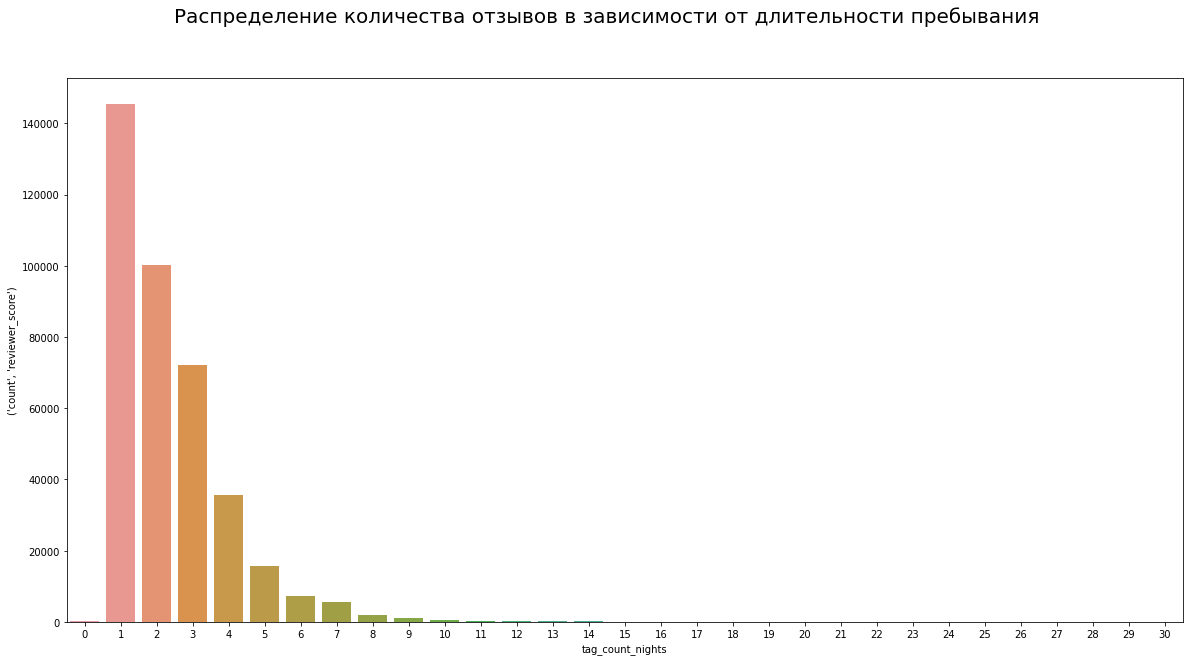

In [450]:
pivot_nights = pd.pivot_table(hotels, index='tag_count_nights', values='reviewer_score', aggfunc=['count', 'mean'])
fig3, ax3 = plt.subplots(figsize=(20, 10))
plt.suptitle('Распределение количества отзывов в зависимости от длительности пребывания', size=20)
sns.barplot(x=pivot_nights.index, y=pivot_nights[('count', 'reviewer_score')]);

***Наибольшие группы - это туристы, совершавшие короткие поездки длительностью 1-3 ночи. Логично, для городских отелей. С возрастанием длительности пребывания - количество отзывов постепенно снижается, а после показателя в 14 ночей (стандартная длина отпуска) - их количество падает резко.***

Странно, что у некоторых данных отсутствует информация о длительности пребывания в отеле. Вообще сайт тщательно проверяет отзывы на реальность.
Возможно это поездки, задним числом аннулированные отелем с возвратом денег туристу, например, а отзыв о пребывании уже был опубликован.
Если обратить внимание на отзывы - то это в основном негативные отзывы.

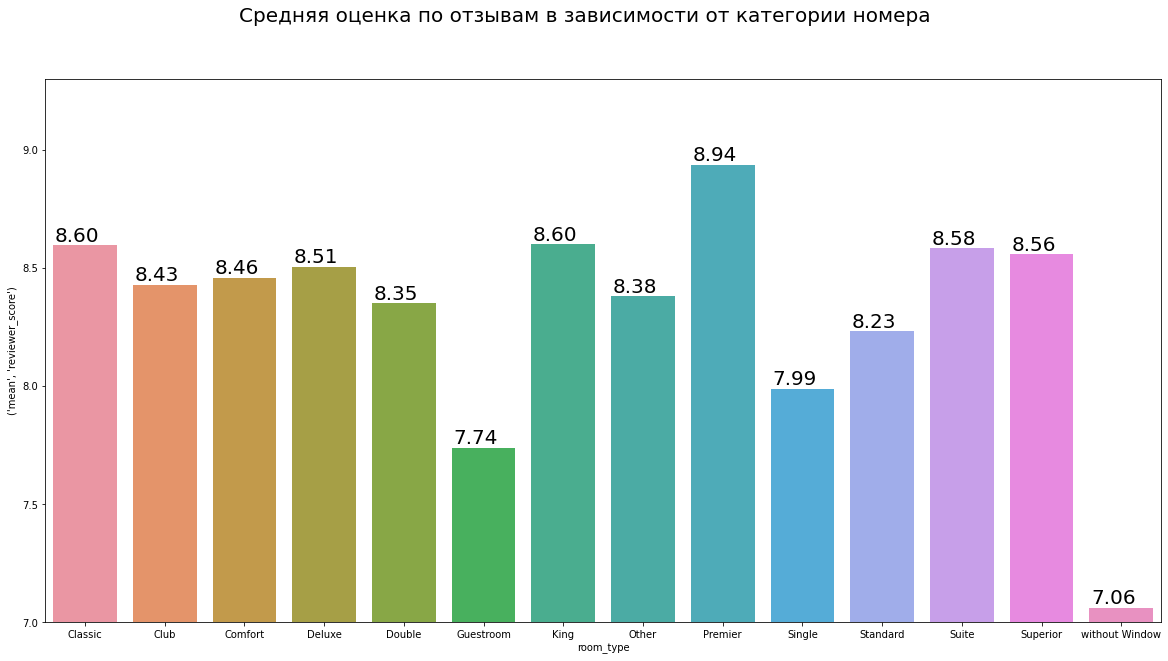

In [451]:
pivot_types = pd.pivot_table(
    hotels, index='room_type', values='reviewer_score', aggfunc=['count', 'mean'])

fig4, ax4 = plt.subplots(figsize=(20, 10))
plt.suptitle('Средняя оценка по отзывам в зависимости от категории номера', size=20)
bar_types = sns.barplot(x=pivot_types.index, y=pivot_types[('mean', 'reviewer_score')])

for p in bar_types.patches:
    bar_types.annotate('{:.2f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()),
    ha='center', va='bottom', fontsize=20)

plt.ylim(7, 9.3);

In [452]:
# удалим ненужные столбцы:
hotels.drop(['tag_reviewer_type', 'room_type', 'tag_room_type', 'len_tags'], axis=1, inplace=True)

### <span style="color:blue">ОБЩЕЕ КОЛИЧЕСТВО ОТЗЫВОВ РЕЦЕНЗЕНТА ('total_number_of_reviews_reviewer_has_given')</span>

Кажется, что такой параметр, как количество отзывов у рецензента - вообще не влияет на оценку отелю. Но возможно, конечно, что более "умудренные опытом" путешественники более требовательны и строги к объекту размещения. Или напротив, люди, которые много путешествуют - лучше знают чего хотят и имеют больше опыта в выборе объекта размещения. А значит, реже разочаровываются... Эти гипотезы нуждаются в проверке.

In [453]:
# Проведем корреляционные тест ANOVA:
_, p = stats.f_oneway(hotels['total_number_of_reviews_reviewer_has_given'], hotels['reviewer_score'])

if p > alpha:
  print(f"{p} > {alpha}. Нет статистически значимого влияния признака.")
else:
  print(f"{p} <= {alpha}. Есть статистически значимое влияние признака.")


print(colored('\nПосмотрим на количество отзывов рецензентов по группам активности:', 'green'))
print(hotels['total_number_of_reviews_reviewer_has_given'].groupby(
    pd.cut(hotels['total_number_of_reviews_reviewer_has_given'], np.arange(0, 360, 25))).agg(
    'count'))

# логарифмируем значение признака, чтобы оставить только информацию о степени (порядке) активности рецензента:
hotels['total_number_of_reviews_reviewer_has_given'] = hotels['total_number_of_reviews_reviewer_has_given'].apply(lambda x: np.log(x+1))

0.0 <= 0.05. Есть статистически значимое влияние признака.

Посмотрим на количество отзывов рецензентов по группам активности:
total_number_of_reviews_reviewer_has_given
(0, 25]       366215
(25, 50]       16316
(50, 75]        2953
(75, 100]        864
(100, 125]       218
(125, 150]       107
(150, 175]        87
(175, 200]        16
(200, 225]        11
(225, 250]         8
(250, 275]         2
(275, 300]         2
(300, 325]         2
(325, 350]         1
Name: total_number_of_reviews_reviewer_has_given, dtype: int64


## 1.3 ХАРКЕТИРСТИКИ ВРЕМЕНИ - ДАТЫ И ПЕРИОДЫ
***Дата размещения отзыва ('review_date')***
***Разница между датой отзыва и датой выгрузки данных ('days_since_review')***

### <span style="color:blue">ДАТА РАЗМЕЩЕНИЯ ОТЗЫВА ('review_date')</span>

У меня есть гипотеза, что на оценку туриста, параметр безусловно субъективный, часто влияет не только опыт пребывания в отеле, но и атмосфера путешествия в целом.
- Не секрет, что лучшим временем для путешествия в крупные европейские города многие считают период зимних новогодних и рождественских праздников. Улицы европейских мегаполисов превращаются в большие рождественские ярмарки и в отелям менеджмент часто создает непринужденную праздничную атмосферу. Кажется это силь должно влиять на общую оценку отелю.
- Весна также прекрасное время для посещения европейских городов. Уже довольно тепло для прогулок, но нет толп назойливых туристов.
- Летом, конечно, спорный период. Это пора отпусков и даже городские отели переполнены. Но долгожданное посещение Парижа или Милана может подпортить жара, например, проблемы с кондиционером, или очереди на завтраке. Персонал часто не справляется с большим потоком посетителей, отсюда, предполагаю что оценки посещения отеля летом будут одними из самых низких.
- Ну и осень. Осенью в Европейских отелях тоже не сладко :D. Начинаются холодные промозглые денечки, в номерах часто холодно и сыро. После летнего туристического сезона именно осенью многие отели устраивают ремонтные работы к рождественским каникулам, что может вызвать дополнительный дискомфорт постояльцев.

Мне кажется, что логичнее всего выделить в отдельные признаки - месяц, неделю и время года посещения отеля.

*PS. В последствии я отказалась от идеи сформировать время года в отдельный признак. И порядковое и категориальное кодирование сезона года ухудшало итоговый MAPE.*

In [454]:
# преобразуем данные в столбце в формат даты/времени:
hotels['review_date'] = pd.to_datetime(hotels['review_date'])

# формируем новые признаки:
hotels['review_week'] = hotels['review_date'].apply(lambda x: x.isocalendar().week)
hotels['review_month'] = hotels['review_date'].dt.month

#### <span style="color:green">Визуализируем влияние месяца посещения отеля на средние настроения туристов:</span>

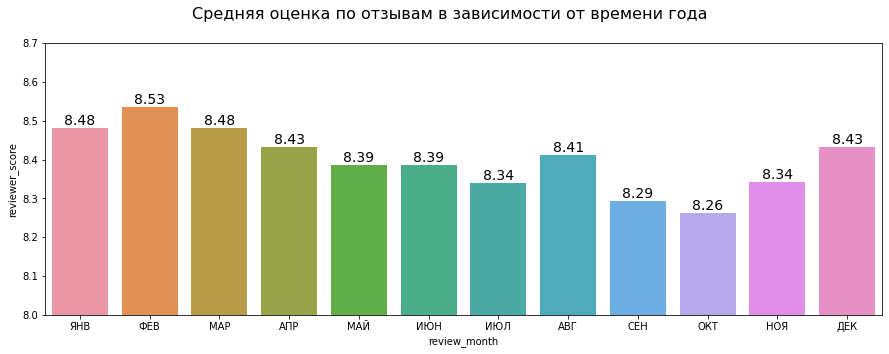

In [455]:
pivot_month = hotels[['review_month', 'reviewer_score']].groupby('review_month').mean()
fig5, ax5 = plt.subplots(figsize=(15, 5))
plt.suptitle('Средняя оценка по отзывам в зависимости от времени года', size=16)
bar_month = sns.barplot(x=pivot_month.index, y=pivot_month['reviewer_score'])
ax5.set_xticklabels(['ЯНВ', 'ФЕВ', 'МАР', 'АПР', 'MAЙ', 'ИЮН', 'ИЮЛ', 'АВГ', 'СЕН', 'ОКТ', 'НОЯ', 'ДЕК'])

for p in bar_month.patches:
    bar_month.annotate('{:.2f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()),
    ha='center', va='bottom', fontsize=14)

plt.ylim(8, 8.7);

Визуализация предварительно подтверждает гипотетическую связь показателей.

In [456]:
# кодируем месяц:
encoder_m = ce.OneHotEncoder(cols=['review_month'], use_cat_names=True)
month_bin = encoder_m.fit_transform(hotels['review_month'])
hotels = pd.concat([hotels, month_bin], axis=1)

# удалим ненужные столбцы:
hotels.drop('review_month', axis = 1, inplace=True)

### <span style="color:blue">ВОЗРАСТ ОТЗЫВА В ДНЯХ ПРИ ВЫГРУЗКЕ ДАННЫХ ('days_since_review')</span>

Вот этот признак, наконец-то, кажется ни с какой стороны не значим :D Удалим его, со спокойной совестью!

In [457]:
hotels.drop('days_since_review', axis = 1, inplace=True)

## 1.4 ОТЗЫВЫ
***Отрицательный отзыв, который рецензент дал отелю ('negative_review')***
***Положительный отзыв, который рецензент дал отелю ('positive_review')***
***Общее количество слов в отрицательном отзыве ('review_total_negative_word_counts')***
***Общее количество слов в положительном отзыве ('review_total_positive_word_counts')***

Структура отзыва об отеле на сайте "Booking.com" устроена таким образом, что содержит в себе две части: Отрицательный отзыв и Положительный отзыв. После выставления оценок по категориям рецензенту предлагается ответить на два вопроса:
- Что вам не понравилось в объекте размещения?
- Что вам понравилось в объекте размещения?

Таким образом получается две части одного по сути ответа.

### <span style="color:blue">КОЛИЧЕСТВО СЛОВ В ОТЗЫВЕ</span>

Эти признаки уже напрямую дают нам информацию о том, удовлетворен ли турист пребыванием в отеле. В большинстве случаев, если все было прекрасно, на вопрос: Что вам не понравилось? - вы не ответите ничего или обойдетесь стандартной фразой типа "Все понравилось" или "Все было прекрасно!". Если же есть на что пожаловаться - эта часть отзыва будет длиннее. С положительной частью - то же самое. Проверим эту гипотезу:

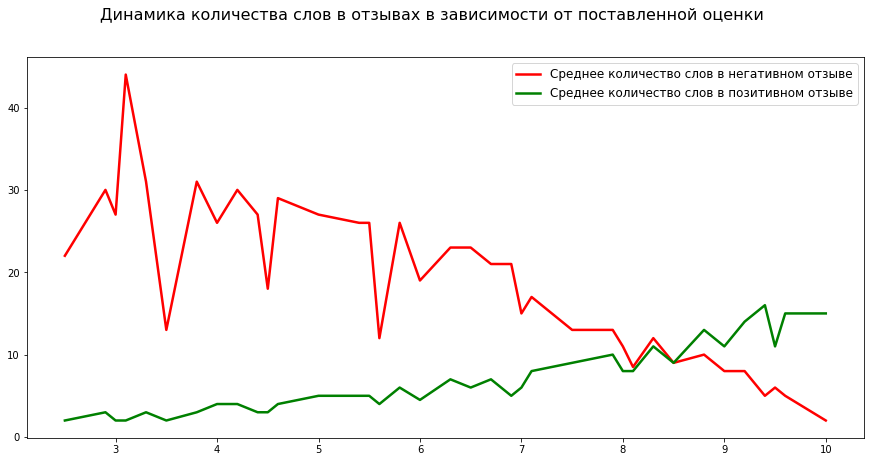

In [458]:
pivot_counts_words_neg = hotels[['reviewer_score', 'review_total_negative_word_counts']].groupby('reviewer_score').median()
pivot_counts_words_pos = hotels[['reviewer_score', 'review_total_positive_word_counts']].groupby('reviewer_score').median()

fig6, ax6 = plt.subplots(figsize=(15, 7))
plt.suptitle('Динамика количества слов в отзывах в зависимости от поставленной оценки', size=16)
line_count_neg = sns.lineplot(
    x=pivot_counts_words_neg.index,
    y=pivot_counts_words_neg['review_total_negative_word_counts'],
    color='red', linewidth=2.5
)
line_count_pos = sns.lineplot(
    x=pivot_counts_words_pos.index,
    y=pivot_counts_words_pos['review_total_positive_word_counts'],
    color='green', linewidth=2.5
)
ax6.set_xlabel('')
ax6.set_ylabel('')
ax6.legend(['Среднее количество слов в негативном отзыве', 'Среднее количество слов в позитивном отзыве'], loc='upper right', fontsize=12);

Очень наглядное подтверждение гипотезы о взаимосвязи количества слов в отзыве и оценки.
Также можно хорошо заметить, что люди больше склонны ругать за недостатки, чем хвалить за достоинства.

In [459]:
# добавим количеству слов в отзыве порядковую характеристику, иными словами - логарифмируем данные:
hotels['review_total_negative_word_counts_log'] = hotels['review_total_negative_word_counts'].apply(lambda x: np.log(x+1))
hotels['review_total_positive_word_counts_log'] = hotels['review_total_positive_word_counts'].apply(lambda x: np.log(x+1))

# а также выделим в отдельные признаки разность и отношение данных величин:
hotels['review_count_diff_word_counts'] = hotels.apply(
    lambda row: row['review_total_positive_word_counts'] - row['review_total_negative_word_counts'], axis=1)
hotels['review_coeff_diff_word_counts'] = hotels.apply(
    lambda row: (row['review_total_positive_word_counts']+1) / (row['review_total_negative_word_counts']+1), axis=1)

### <span style="color:blue">НЕПОСРЕДСТВЕННО ОТЗЫВ (‘negative_review’, ‘positive_review’)</span>

А теперь - самое интересное:D
Огромное количество информации для лучшего предсказания итоговой оценки содержится именно в этих столбцах!
Но для того чтобы параметрически оценить эти данны - нужен будет лингвистический анализ текста. Я попробую два подхода:
1) VADER (Valence Aware Dictionary and sEntiment Reasoner) — это основанный на лексике и правилах инструмент анализа настроений, специально настроенный на чувства, выраженные в социальных сетях.
<a href="https://github.com/cjhutto/vaderSentiment">Библиотека на GitHub тут</a>
2) TextBlob — это библиотека Python (2 и 3) для обработки текстовых данных. Он предоставляет простой API для погружения в общие задачи обработки естественного языка (NLP), такие как тегирование частей речи, извлечение именной фразы, анализ тональности, классификация, перевод и многое другое.
<a href="https://textblob.readthedocs.io/en/dev/">Ссылка на сайт библиотеки тут</a>
<a href="https://buildmedia.readthedocs.org/media/pdf/textblob/latest/textblob.pdf">Документация TextBlob</a>

Первоначально я пробовала еще один подход с очисткой и лемматизацией текста, но он оказался не так эффективен, как вышеописанные, поэтому я от него отказалась. Но хорошие визуализации словарных, созданные в процессе этой работы остались:

In [460]:
# визуализируем основные слова положительных и отрицательных частей отзывов
# загружаем словарь для лемматизации
nlp = spacy.load('en_core_web_sm')
stop = stopwords.words('english')
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()


def clean_text(text):
    text = text.lower()
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    text = [word for word in text if not any(c.isdigit() for c in word)]
    text = [word for word in text if word not in stop]
    text = " ".join(text)
    return text


def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]


hotels['negative_review_temp'] = hotels['negative_review'].apply(lambda x: x.replace('No Negative', ''))
hotels['positive_review_temp'] = hotels['positive_review'].apply(lambda x: x.replace('No Positive', ''))

hotels['positive_review_clean'] = hotels['positive_review_temp'].apply(clean_text)
hotels['negative_review_clean'] = hotels['negative_review_temp'].apply(clean_text)

hotels['positive_review_lemmatized'] = hotels['positive_review_clean'].apply(lemmatize_text)
hotels['negative_review_lemmatized'] = hotels['negative_review_clean'].apply(lemmatize_text)

# визуализируем словарные наборы:
def get_words_string(words_data):
    words_string = ''
    for word in words_data:
        words_string = words_string + word + ' '
    return words_string

ОБЛАКО СЛОВ ПОЗИТИВНЫХ ОТЗЫВОВ:



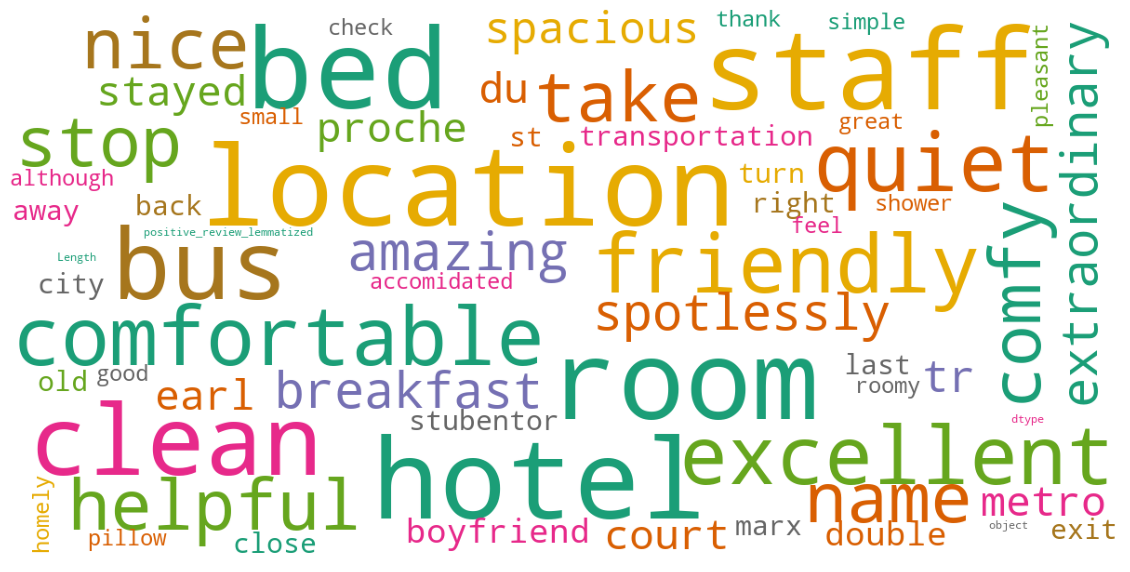

In [461]:
print('ОБЛАКО СЛОВ ПОЗИТИВНЫХ ОТЗЫВОВ:\n')
cloud = hotels['positive_review_lemmatized'].apply(get_words_string)
# воспользуемся функцией для визуализации тегов:
show_wordcloud(cloud, 'white', 'Dark2')

ОБЛАКО СЛОВ НЕГАТИВНЫХ ОТЗЫВОВ:



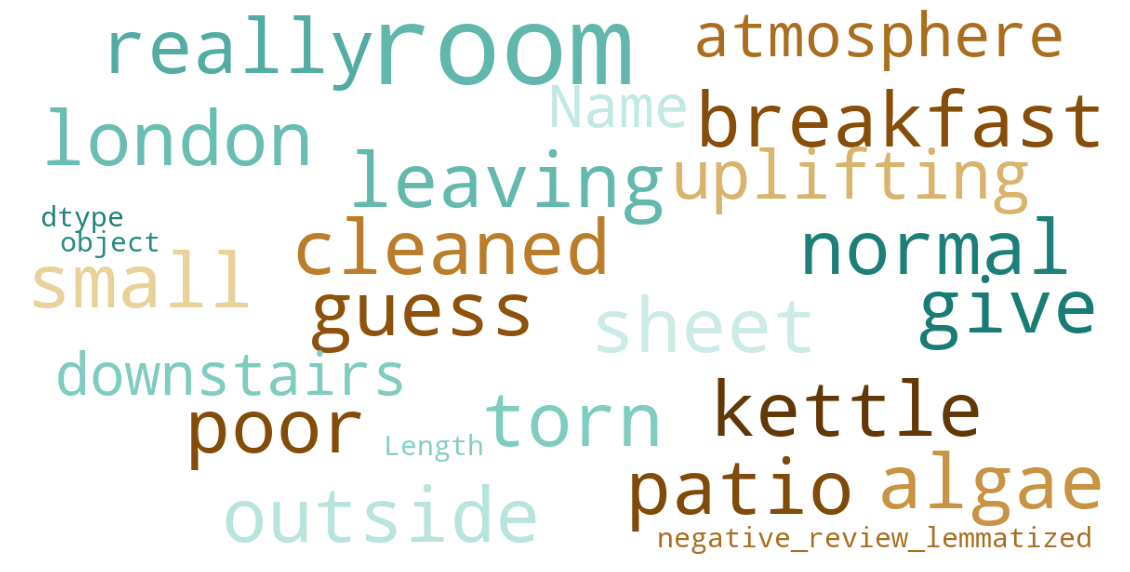

In [462]:
print('ОБЛАКО СЛОВ НЕГАТИВНЫХ ОТЗЫВОВ:\n')
cloud = hotels['negative_review_lemmatized'].apply(get_words_string)
show_wordcloud(cloud, 'white', 'BrBG')

### Анализ настроений с помощью SentimentIntensityAnalyzer библиотеки VADER:

SentimentIntensityAnalyzer от VADER выводит оценку на 3 уровнях классификации, а также составную оценку.
В результате мы получим словарь нормализованных оценок тональности текста по категориям:
- негативная оценка
- нейтральная оценка
- позитивная

И все бы хорошо, но одни и те же слова в положительном и отрицательном контекстах будут иметь противоположную тональность.

Вспомним, что положительный и отрицательные части отзыва  - это ответы на два вопроса сайта о том что понравилось / не понравилось в отеле. А структура английского языка такова (как выяснилось), что ответ на вопрос "Что вам не понравилось?": "Ничего" (nothing) - будет означать, что ничего не не понравилось, то есть - все понравилось. Самый положительный контекст. Но тоже самое "Ничего" в ответ на вопрос: "Что вам понравилось?" будет означать ровно обратное.

А вот слово "все" (everything) такой семантики не имеет (вроде бы).

Эти слова изначально для анализатора имеют нейтральную тональность, но в качестве ответа на вопрос, хорошо было бы эту тональность именно таких самых популярных слов изменить. Причем разным образом для разных частей отзывов.

Так же слово "small" мы встретим в огромной части отрицательных отзывов - Small room, Small bed, Small pool. И невинно нейтральное small в отрицательных отзывах об отелях принимает негативный контекст.

Для работы с разными частями отзывов я создам два разных анализатора - SentimentIntensityAnalyzer, а лексикон каждого настрою для соответствующей части отзывов.

И еще один момент. Вообще метками 'No Negative' / 'No Positive' обозначается отсутствие отзыва. Но для нас отсутствие отрицательно  отзыва - означает - отсутствие отрицательного опыта пребывания и наоборот, по этому оставим эти фразы для анализа, предварительно переформулировав фразы без "не".

In [463]:
%%time

# создаем два экземпляра анализатора, чтобы разделить лексикон для оценки положительных и отрицательных отзывов:
sia_pos = SentimentIntensityAnalyzer()
sia_neg = SentimentIntensityAnalyzer()

# посмотрим как изменится характеристика слова 'nothing':
example = 'nothing'
print(f'Словарь оценок слова "{example}" до преобразований: {sia_neg.polarity_scores(example)}')

# добавим контекст:
# по всей видимости негативный и позитивный индекс присваивается по логарифмической шкале, поэтому, разграничим величину позитивного / негативного контекста числом разрядов:
neg_words = {'small': -1, 'nothing': 10}
pos_words = {'nothing': -10, 'everything': 10}
sia_neg.lexicon.update(neg_words)
sia_pos.lexicon.update(pos_words)

print(f' - после преобразований (для негативного контекста): {sia_neg.polarity_scores(example)}')
print(f' - после преобразований (для позитивного контекста): {sia_pos.polarity_scores(example)}')

# меняем метки отсутствия частей отзыва:
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: x.replace('No Negative', 'Positive'))
hotels['positive_review'] = hotels['positive_review'].apply(lambda x: x.replace('No Positive', 'Negative'))

# понеслась?)
hotels['negative_review_sentiments'] = hotels['negative_review'].apply(lambda x: sia_neg.polarity_scores(x))
hotels['positive_review_sentiments'] = hotels['positive_review'].apply(lambda x: sia_pos.polarity_scores(x))

# формируем новые признаки:
hotels['negative_review_sentiments_neg'] = hotels['negative_review_sentiments'].apply(lambda x: x['neg'])
hotels['negative_review_sentiments_neu'] = hotels['negative_review_sentiments'].apply(lambda x: x['neu'])
hotels['negative_review_sentiments_pos'] = hotels['negative_review_sentiments'].apply(lambda x: x['pos'])
hotels['negative_review_sentiments_compound'] = hotels['negative_review_sentiments'].apply(lambda x: x['compound'])

hotels['positive_review_sentiments_neg'] = hotels['positive_review_sentiments'].apply(lambda x: x['neg'])
hotels['positive_review_sentiments_neu'] = hotels['positive_review_sentiments'].apply(lambda x: x['neu'])
hotels['positive_review_sentiments_pos'] = hotels['positive_review_sentiments'].apply(lambda x: x['pos'])
hotels['positive_review_sentiments_compound'] = hotels['positive_review_sentiments'].apply(lambda x: x['compound'])

Словарь оценок слова "nothing" до преобразований: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
 - после преобразований (для негативного контекста): {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.9325}
 - после преобразований (для позитивного контекста): {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.9325}
CPU times: user 2min 42s, sys: 1.53 s, total: 2min 44s
Wall time: 2min 48s


### Анализ настроений с помощью TextBlob:

TextBlob работает немного по другому.

Полярность — это число с плавающей запятой от -1 до 1, где -1 — отрицательное утверждение, а 1 — положительное утверждение.
Субъективность — это показатель TextBlobs , определяющий, считается ли утверждение в большей степени личным мнением или оно основано на фактах.

Для оценки настроения рецензента будем использовать параметр полярности.

Также мы получим классификацию настроений в негативной и позитивной частях отзыва и, на основе этих данных выведем категорию отзыва, руководствуясь следующей логикой:

***- (восторженный) обе части имеют позитивную тональность: высшая категория***
туристу так все понравилось, что и в ответе на вопрос о недостатках - он выражает положительные эмоции

***- (конструктивный) позитивная часть имеют позитивную тональность, негативная часть - негативную: средняя высокая категория***
объективный поиск достоинств и недостатков отеля

***- (снисходительный) позитивная часть имеет негативную тональность, негативная - позитивную: средняя низкая категория***
пребывание скорее не понравилось, но отзыв о недостатках не жесткий

***- (разочарованный) обе части имеют негативную тональность: низшая категория***
ничего не понравилось

Исходя из шкалы оценивания отеля - выберем 4 оценки в диапазоне от 2.5 до 10 с равным шагом.

In [464]:
%%time
hotels['negative_review_temp'] = hotels['negative_review'].apply(lambda x: x.lower().replace('nothing', 'Negative'))
hotels['positive_review_temp'] = hotels['positive_review'].apply(lambda x: x.lower().replace('everything', 'Positive'))


def get_polarity(text):
    blob = TextBlob(text)
    return blob.sentiment_assessments.polarity


hotels['negative_polarity'] = hotels['negative_review_temp'].apply(get_polarity)
hotels['positive_polarity'] = hotels['positive_review_temp'].apply(get_polarity)

tb = textblob.Blobber(analyzer=NaiveBayesAnalyzer())
for index, row_h in hotels.iterrows():
    sent_neg = tb(row_h['negative_review_temp']).sentiment
    hotels.loc[index, 'negative_review_class'] = sent_neg[0]
    hotels.loc[index, 'negative_review_pos'] = sent_neg[1]
    hotels.loc[index, 'negative_review_neg'] = sent_neg[2]

    sent_pos = tb(row_h['positive_review_temp']).sentiment
    hotels.loc[index, 'positive_review_class'] = sent_pos[0]
    hotels.loc[index, 'positive_review_pos'] = sent_pos[1]
    hotels.loc[index, 'positive_review_neg'] = sent_pos[2]

hotels['positive_review_class'] = hotels['positive_review_class'].apply(lambda x: 1 if x == 'pos' else 0)
hotels['negative_review_class'] = hotels['negative_review_class'].apply(lambda x: 1 if x == 'pos' else 0)
# мы получили 6 новых признаков

# добавляем параметр с классификацией отзыва:
def get_review_classification(positive_review_class, negative_review_class):
    if positive_review_class + negative_review_class == 2:
        return 10.0
    if positive_review_class == 1 and negative_review_class == 0:
        return 7.5
    if positive_review_class == 0 and negative_review_class == 1:
        return 5.0
    return 2.5

hotels['review_classification'] = hotels.apply(
    lambda row: get_review_classification(row['positive_review_class'], row['negative_review_class']), axis=1)

CPU times: user 11min 36s, sys: 3.85 s, total: 11min 40s
Wall time: 11min 52s


# 2. Анализ и отбор признаков (FEATURE SELECTION):

### Разделим все признаки на группы:

In [474]:
print(f'Текущее получившееся количество признаков: {len(hotels.columns)}')

# удалим нечисловые данные:
object_columns = [s for s in hotels.columns
                  if ((hotels[s].dtypes == 'object') | (hotels[s].dtypes == 'category') | (hotels[s].dtypes == 'datetime64[ns]'))]

print(f'Удалим {len(object_columns)} столбцов с нечисловыми данными.')

hotels.drop(object_columns, axis = 1, inplace=True)

Текущее получившееся количество признаков: 94
Удалим 19 столбцов с нечисловыми данными.


In [526]:
# делим оставшиеся столбцы на непрерывные и категориальные признаки:
num_cols = [
    'review_total_negative_word_counts', 'review_total_positive_word_counts',
    'review_total_negative_word_counts_log', 'review_total_positive_word_counts_log',
    'total_number_of_reviews_reviewer_has_given',
    'tag_count_nights',
    'review_count_diff_word_counts', 'review_coeff_diff_word_counts',
    'negative_review_sentiments_neg', 'negative_review_sentiments_neu',
    'negative_review_sentiments_pos', 'negative_review_sentiments_compound',
    'positive_review_sentiments_neg', 'positive_review_sentiments_neu',
    'positive_review_sentiments_pos', 'positive_review_sentiments_compound',
    'negative_polarity', 'positive_polarity',
    'negative_review_pos', 'negative_review_neg',
    'positive_review_pos', 'positive_review_neg',

]

cat_cols = [
    # характеристики отеля
    'average_score', 'hotel_code', 'hotel_country_code',
    'district_code', 'district_rating', 'hotel_distance_to_center',

    # характеристики поездки (номер):
    'tag_business_trip', 'tag_leisure_trip', 'tag_view_room',
    'room_type_Suite', 'room_type_Standard', 'room_type_Double', 'room_type_Superior', 'room_type_Club',
    'room_type_Comfort', 'room_type_Deluxe', 'room_type_without Window', 'room_type_Premier',
    'room_type_Classic', 'room_type_King', 'room_type_Single', 'room_type_Guestroom', 'room_type_Other',

    # характеристики рецензента:
    'reviewer_en', 'reviewer_n_est', 'reviewer_resident', 'reviewer_nationality_cat',
    'tag_from_mobile', 'tag_with_pet',
    'tag_reviewer_type_1.0', 'tag_reviewer_type_2.0', 'tag_reviewer_type_3.0',
    'tag_reviewer_type_4.0', 'tag_reviewer_type_5.0', 'tag_reviewer_type_6.0',

    # время поездки:
    'review_week',
    'review_month_1.0', 'review_month_2.0', 'review_month_3.0', 'review_month_4.0',
    'review_month_5.0', 'review_month_6.0', 'review_month_7.0', 'review_month_8.0',
    'review_month_9.0', 'review_month_10.0', 'review_month_11.0', 'review_month_12.0',

    # характеристики отзыва:
    'negative_review_class', 'positive_review_class', 'review_classification'
]

## 2.1 АНАЛИЗ МУЛЬТИКОЛЛИНЕАРНОСТИ

Поскольку признаков очень много оценим коллинеарность по смысловым группам:

### АНАЛИЗ МУЛЬТИКОЛЛИНЕАРНОСТИ НЕПРЕРЫВНЫХ ПРИЗНАКОВ

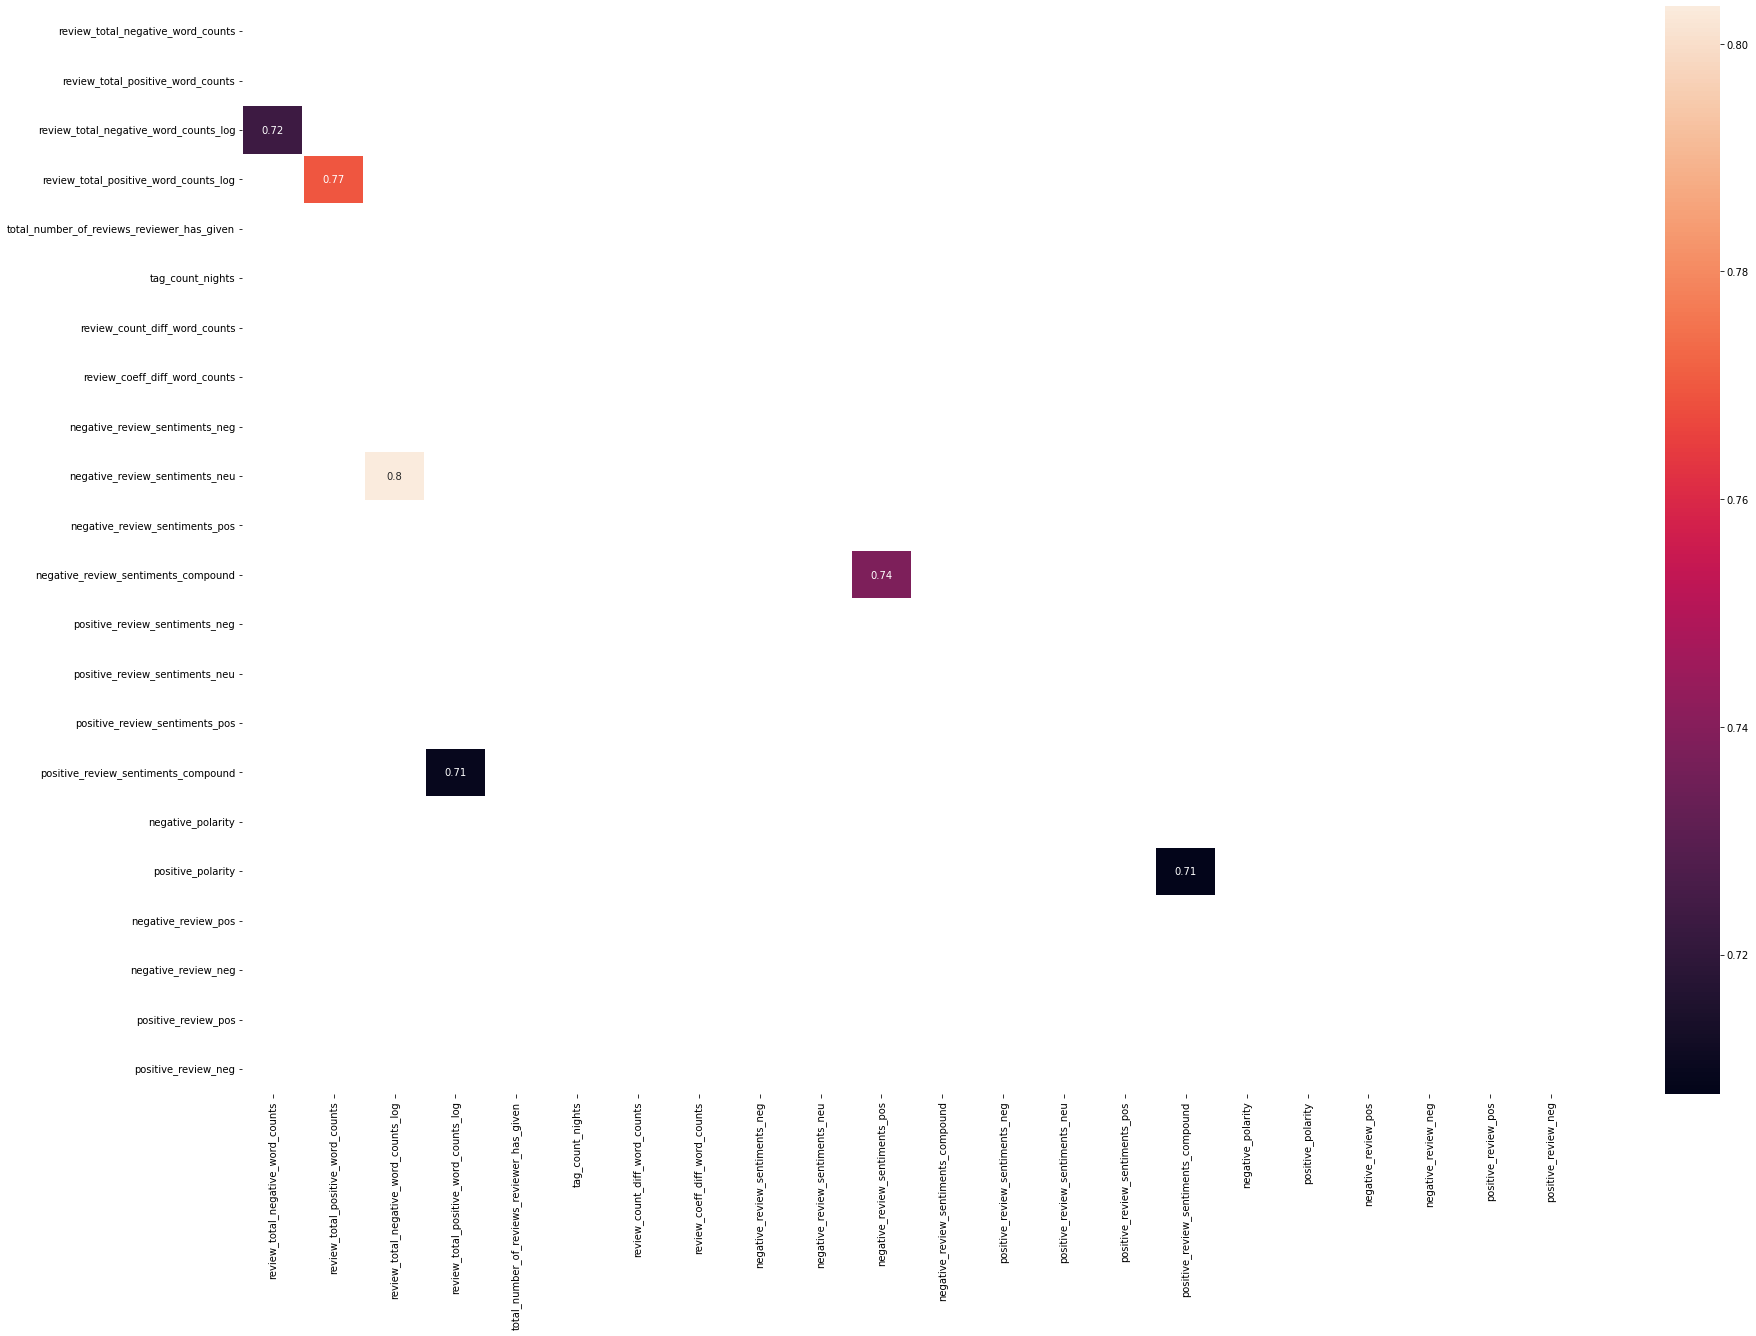

In [493]:
fig, ax = plt.subplots(figsize=(30, 20))
corr = hotels[num_cols].corr()
highcorr = corr[corr >= .7]
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(highcorr, annot=True, linewidths=0.1, ax=ax, mask=mask)

plt.show();

***Получилось 6 пар сильно коррелирующих между собой признака. Удалим логарифмирование длины отзывов. Два этих признака участвуют в 4 наиболее коррелирующих парах.***

In [497]:
hotels.drop(['review_total_negative_word_counts_log', 'review_total_positive_word_counts_log'], axis = 1, inplace=True)

num_cols.remove('review_total_negative_word_counts_log')
num_cols.remove('review_total_positive_word_counts_log')

KeyError: "['review_total_negative_word_counts_log', 'review_total_positive_word_counts_log'] not found in axis"

### АНАЛИЗ МУЛЬТИКОЛЛИНЕАРНОСТИ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ

Разделим категориальные признаки на 2 смысловые группы:

In [528]:
# в первый блок отнесем характеристики отеля и номера:
cat_cols_p1 = cat_cols[:23]

# во второй блок - характеристики рецензента, времени поездки и отзыва:
cat_cols_p2 = cat_cols[23:]

['average_score', 'hotel_code', 'hotel_country_code', 'district_code', 'district_rating', 'hotel_distance_to_center', 'tag_business_trip', 'tag_leisure_trip', 'tag_view_room', 'room_type_Suite', 'room_type_Standard', 'room_type_Double', 'room_type_Superior', 'room_type_Club', 'room_type_Comfort', 'room_type_Deluxe', 'room_type_without Window', 'room_type_Premier', 'room_type_Classic', 'room_type_King', 'room_type_Single', 'room_type_Guestroom', 'room_type_Other']
['reviewer_en', 'reviewer_n_est', 'reviewer_resident', 'reviewer_nationality_cat', 'tag_from_mobile', 'tag_with_pet', 'tag_reviewer_type_1.0', 'tag_reviewer_type_2.0', 'tag_reviewer_type_3.0', 'tag_reviewer_type_4.0', 'tag_reviewer_type_5.0', 'tag_reviewer_type_6.0', 'review_week', 'review_month_1.0', 'review_month_2.0', 'review_month_3.0', 'review_month_4.0', 'review_month_5.0', 'review_month_6.0', 'review_month_7.0', 'review_month_8.0', 'review_month_9.0', 'review_month_10.0', 'review_month_11.0', 'review_month_12.0', 'negat

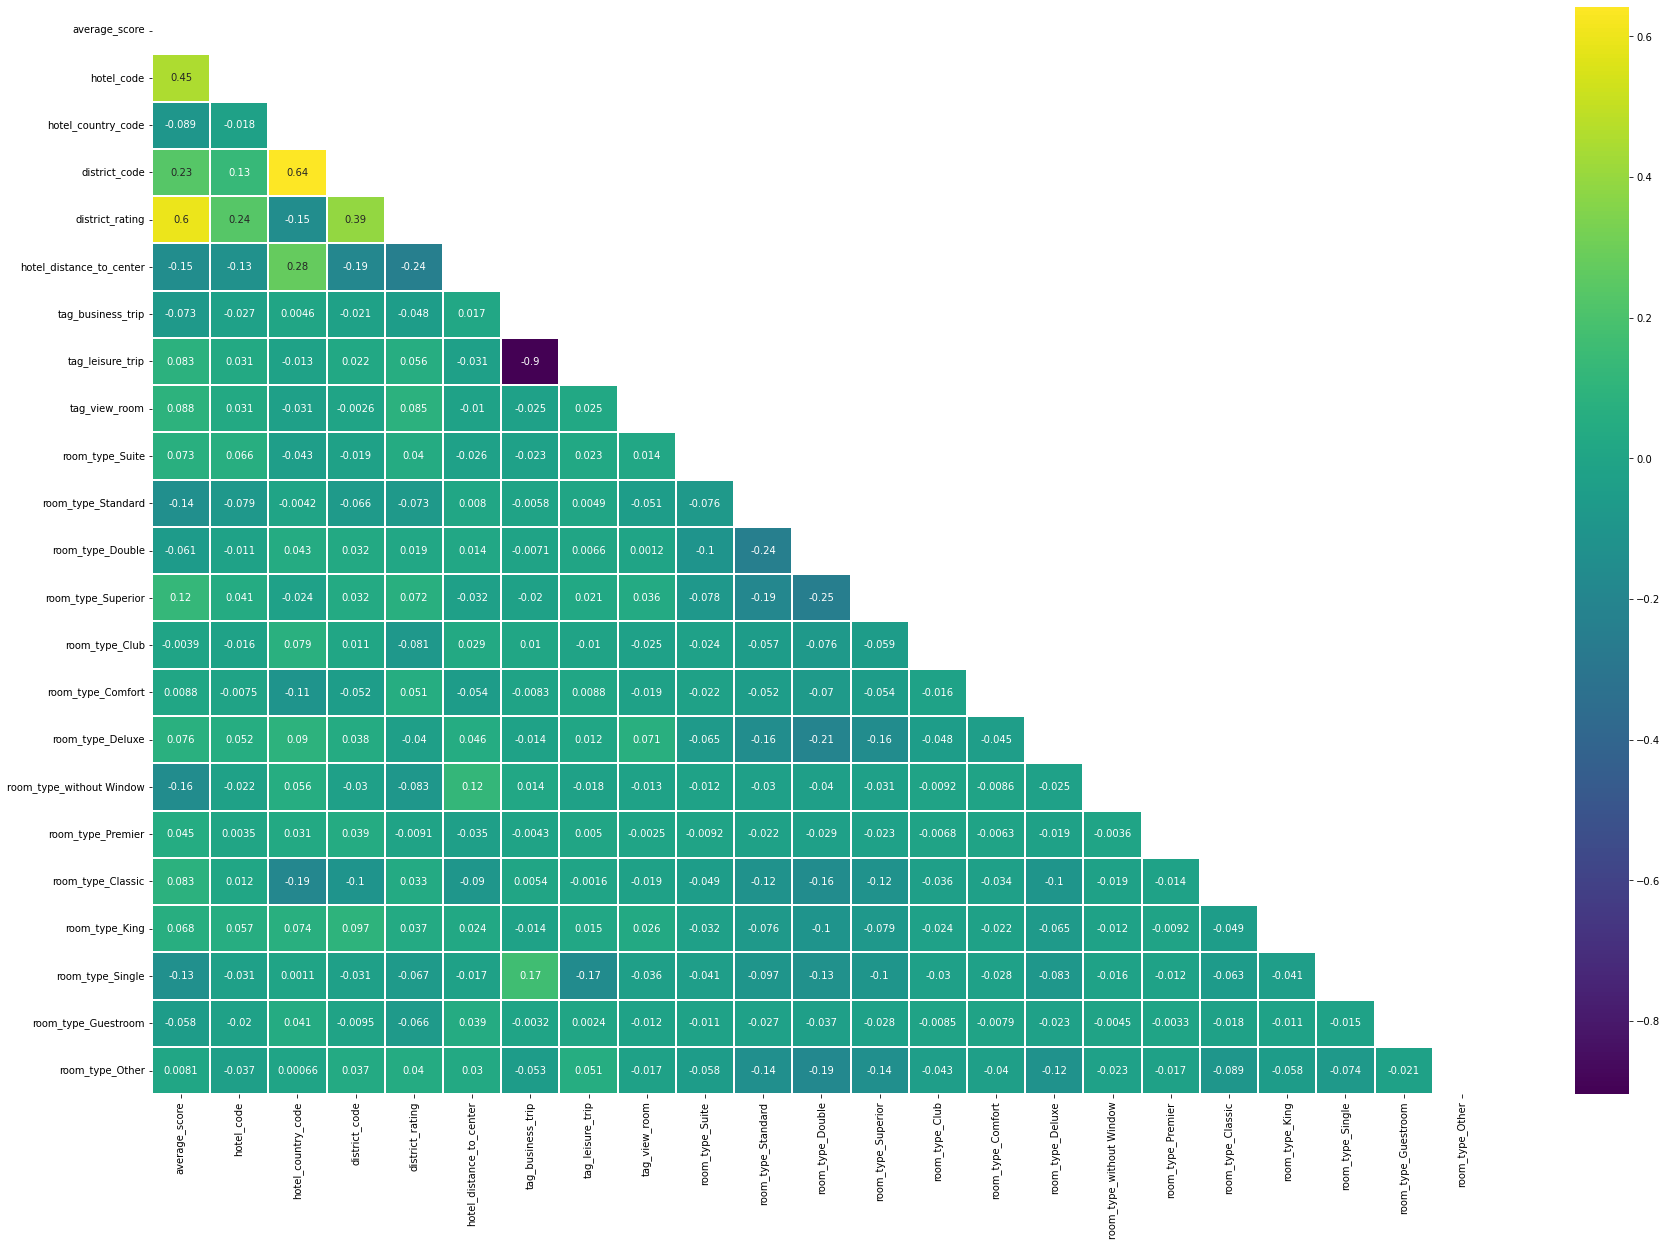

In [532]:
fig2, ax = plt.subplots(figsize=(30, 20))
corr = hotels[cat_cols_p1].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, linewidths=0.1, ax=ax, mask=mask, cmap='viridis')

plt.show();

***Замечаем сильную обратную корреляцию признаков "Отдых" и "Командировка". Это очень логично, но поскольку не все туристы выбирали какое-то из этих значений в тегах, изначально я оставила оба значения. Теперь понятно, что одно из них можно удалить.***

In [534]:
hotels.drop('tag_business_trip', axis = 1, inplace=True)

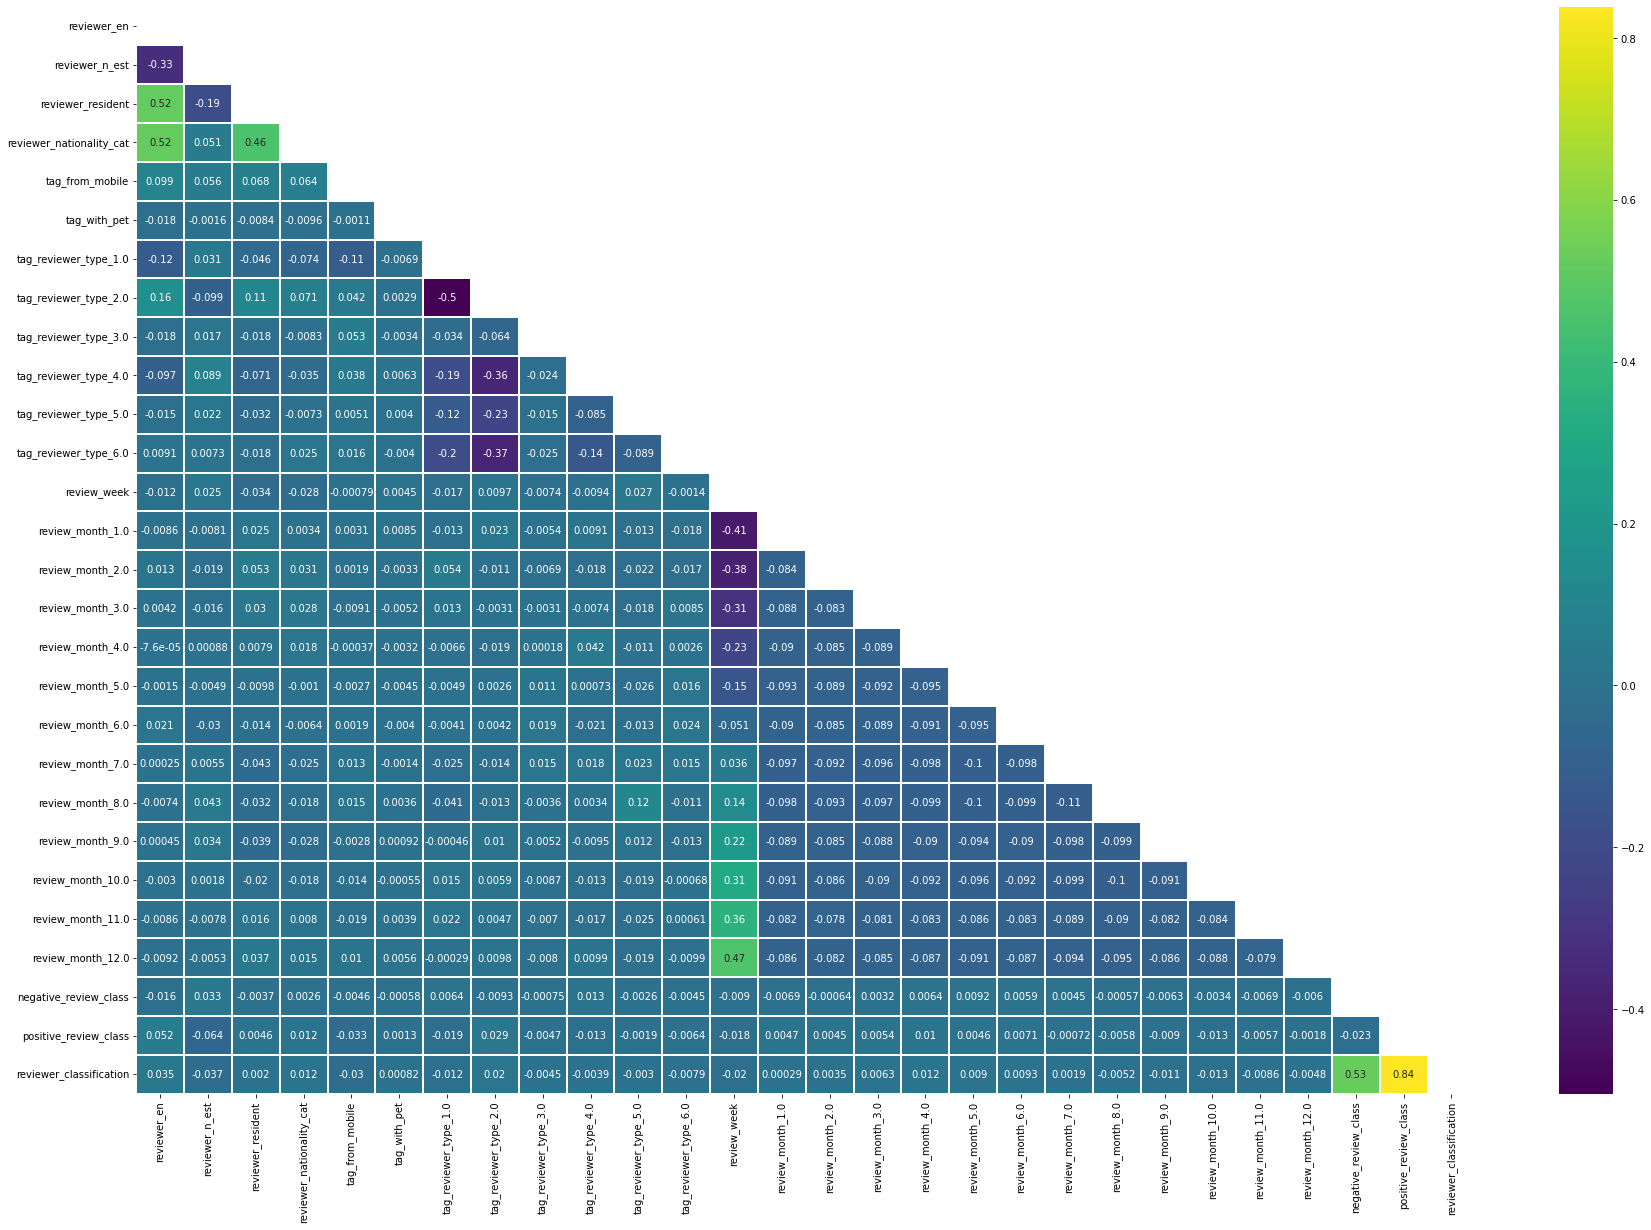

In [533]:
fig3, ax = plt.subplots(figsize=(30, 20))
corr = hotels[cat_cols_p2].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, linewidths=0.1, ax=ax, mask=mask, cmap='viridis')

plt.show();

***А из этого списка удаляем признак с категорией отзыва. Он основан на признаке позитивного или негативного класса, поэтому показывает сильную с ними корреляцию.***

In [535]:
hotels.drop('review_classification', axis = 1, inplace=True)

## 2.2 АНАЛИЗ

# 3. Обучение модели и получение предсказания:

In [536]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)
X_df = hotels.drop(['reviewer_score'], axis = 1)
y = hotels['reviewer_score']

In [537]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.25, random_state=42)

In [538]:
%%time

# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

CPU times: user 10min 43s, sys: 4.04 s, total: 10min 47s
Wall time: 11min 1s


In [525]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.11916772317647376


In [539]:
def mean_absolute_percentage_error(y_tr, y_pr):
    y_tr, y_pr = np.array(y_tr), np.array(y_pr)
    return np.mean(np.abs((y_tr - y_pr) / y_tr)) * 100


print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MAE: 0.8389436096834569
MAPE: 11.91995966653454
